In [1]:
import sys
sys.path.append("../")

import jax
import jax.numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import optax
from tqdm import tqdm, trange
import flax

import math
from functools import partial
import matplotlib.pyplot as plt

# Ensure TF does not see GPU and grab all GPU memory
tf.config.experimental.set_visible_devices([], "GPU")

from models.mlp_mixer import MLPMixer
from models.consistency_utils import timestep_embedding, timestep_discretization
from models.train_utils import TrainState, apply_ema_decay

In [2]:
# Config
num_batch = 512
d_t_emb = 16
sigma_data = 0.5
s0 = 2
s1 = 150
sigma = 7.
mu0 = 0.9
eps = 0.002
T = 80.0

In [3]:
def get_mnist_dataset(split, batch_size):
    """Returns an iterator over the MNIST dataset."""
    # Load the dataset and prepare it for batching
    ds = tfds.load('mnist', split=split, shuffle_files=True if split == "train" else False)
    ds = ds
    
    # Define a function to preprocess each batch
    def preprocess(batch):
        mean, std = 0.1307, 0.3081
        images = batch['image']
        # Flatten the images and normalize their pixel values to [0, 1]
        images = tf.cast(images, tf.float32) / 255
        images = 2. * images - 1.
        labels = batch['label']
        return images, labels
    
    # Map the preprocessing function to each batch
    ds = ds.map(preprocess).batch(batch_size).cache().repeat()
    
    # Return an iterator over the preprocessed batches
    return iter(ds)

batches = get_mnist_dataset("train", num_batch)

In [4]:
def f_theta(params, score, x, t, y):
    """ The consistency model.
    """

    c_skip = sigma_data ** 2 / ((t - eps) ** 2 + sigma_data ** 2)
    c_out = sigma_data * (t - eps) / np.sqrt(sigma_data ** 2 + t ** 2)

    t = t[..., 0]
    t = timestep_embedding(t, d_t_emb)
    x_out = score.apply(params, x, t, y)

    return x * c_skip[:, :, None, None] + x_out * c_out[:, :, None, None]

@partial(jax.jit, static_argnums=(5,))
def loss_fn(params, params_ema, x, t1, t2, score, key, y):
    """ Discrete timestep consistency loss function.
    """

    z = jax.random.normal(key, shape=x.shape)

    x2 = x + z * t2[:, :, None, None]
    x2 = f_theta(params, score, x2, t2, y)

    x1 = x + z * t1[:, :, None, None]
    x1 = f_theta(params_ema, score, x1, t1, y)

    return np.mean((x1 - x2) ** 2)

@partial(jax.jit, static_argnums=(5,6,))
def train_step(state, batch, t1, t2, key, model, loss_fn, mu):
    """ Single train step.
    """
    x_batch, y_batch = batch
    loss, grads = jax.value_and_grad(loss_fn)(state.params, state.params_ema, x_batch, t1, t2, model, key, y_batch)
    state = state.apply_gradients(grads=grads)
    state = apply_ema_decay(state, mu)
    return state, loss

In [5]:
score = MLPMixer(patch_size=4, num_blocks=4, hidden_dim=128, tokens_mlp_dim=512, channels_mlp_dim=512, num_classes=10)

key = jax.random.PRNGKey(42)
x = jax.random.normal(key, (4, 28, 28, 1))
t = np.ones((4, d_t_emb))
context = np.ones((4,)).astype(np.int32)

params = score.init(key, x, t, context)

tx = optax.adamw(learning_rate=3e-4, weight_decay=1e-4)
state = TrainState.create(apply_fn=score.apply, params=params, tx=tx, params_ema=params)

In [ ]:
num_steps = 100_000

with trange(num_steps) as steps:
    for step in steps:
        
        # Get a data batch
        x_batch, y_batch = next(batches)
        x_batch, y_batch = x_batch._numpy(), y_batch._numpy()
        
        # Timestep discretization and EMA schedule from paper
        N = math.ceil(math.sqrt((step * ((s1 + 1) ** 2 - s0 ** 2) / num_steps) + s0 ** 2) - 1) + 1
        mu = math.exp(s0 * math.log(mu0) / N)
        boundaries = timestep_discretization(sigma, eps, N, T)
        
        # Draw timesteps from discretized schedule
        key, _ = jax.random.split(key)
        n_batch = jax.random.randint(key, minval=0, maxval=N - 1, shape=(x_batch.shape[0], 1))
        
        key, _ = jax.random.split(key)
        state, loss = train_step(state, (x_batch, y_batch), boundaries[n_batch], boundaries[n_batch + 1], key, score, loss_fn, mu)

        steps.set_postfix(val=loss)

 36%|███████████                    | 35814/100000 [23:37<37:23, 28.61it/s, val=0.0003178383]

In [8]:
def sample(params, score, timesteps, key, label):
    """ Draw a sample from consistency model.
    """
    x0 = jax.random.normal(key, shape=(n_samples, 28, 28, 1)) * timesteps[0]
    
    x = f_theta(params, score, x0, np.repeat(timesteps[0], x0.shape[0])[:, None], y)
    for t in timesteps[1:]:
        key, _ = jax.random.split(key)
        z = jax.random.normal(key, shape=x0.shape)
        x = x + math.sqrt(t ** 2 - eps ** 2) * z
        x = f_theta(params, score, x, np.repeat(t, x0.shape[0])[:, None], y)
    return x

n_samples = 16
key = jax.random.PRNGKey(420)

y = np.arange(16) % 10

# Generate samples with 5 and 2 steps
x_samples_5 = sample(state.params, score, list(reversed([1., 5., T / 4., T / 2., T])), key, y)
x_samples_2 = sample(state.params, score, list(reversed([1., T])), key, y)

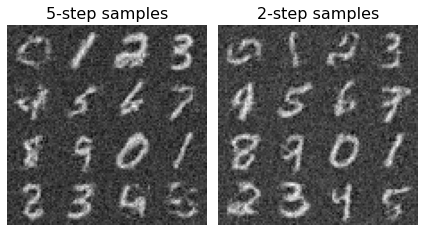

In [9]:
from einops import rearrange

x_samples_5_plot = rearrange(x_samples_5, "(n1 n2) h w 1 -> (n1 h) (n2 w)", n1=4)
x_samples_2_plot = rearrange(x_samples_2, "(n1 n2) h w 1 -> (n1 h) (n2 w)", n1=4)

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(x_samples_5_plot, cmap="binary_r")
ax1.axis("off")
ax1.set_title("5-step samples", fontsize=16)

ax2.imshow(x_samples_2_plot, cmap="binary_r")
ax2.axis("off")
ax2.set_title("2-step samples", fontsize=16)

plt.tight_layout()
plt.savefig("plots/mnist_samples.png")